In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam, SGD

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

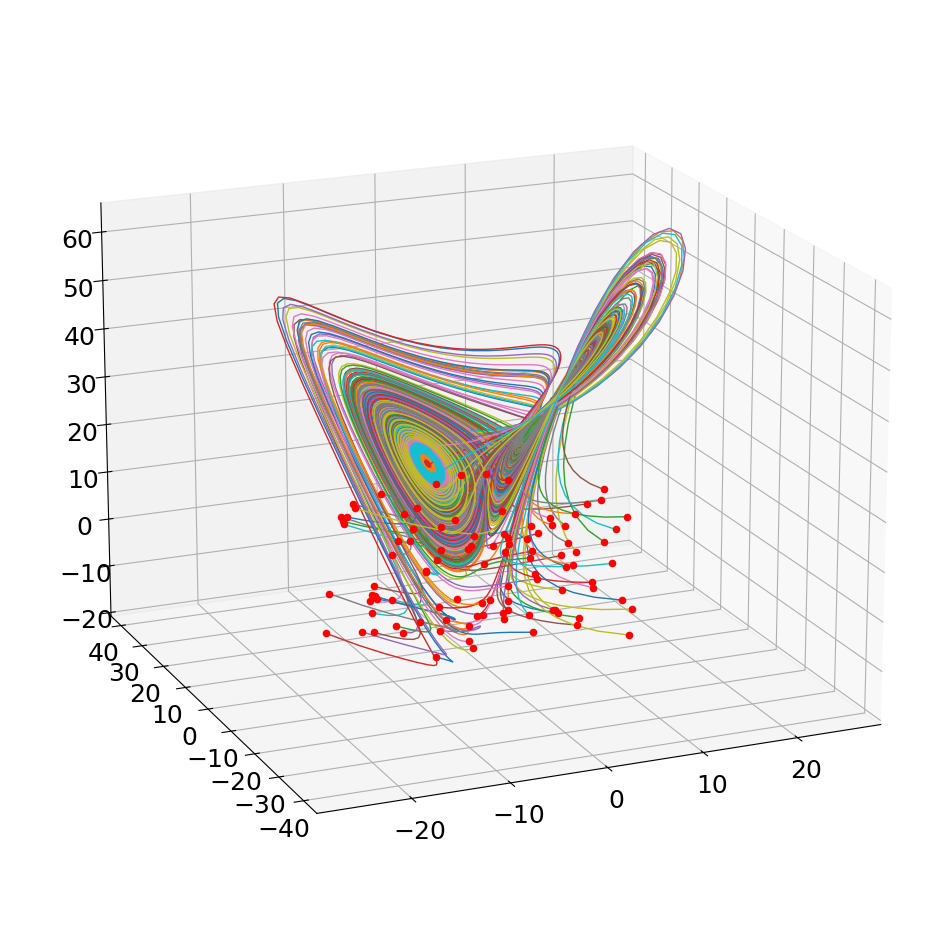

In [2]:
## Simulate the Lorenz System

dt = 0.01
T = 8
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28


nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             
ax.view_init(18, -113)
plt.show()

# Neural Net

In [10]:
## Neural Net

# --- Normalize the data (critical for training) ---
input_mean = nn_input.mean(axis=0)
input_std  = nn_input.std(axis=0)
output_mean = nn_output.mean(axis=0)
output_std  = nn_output.std(axis=0)

nn_input_norm  = (nn_input  - input_mean) / input_std
nn_output_norm = (nn_output - output_mean) / output_std

# Create model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(3,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(nn_input_norm, nn_output_norm, epochs=50, batch_size=256, validation_split=0.1)

Epoch 1/50


/Users/tzikos/Desktop/DTU/4th Semester/Data-driven methods/Exercises/Data-Driven-Methods/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0477 - val_loss: 9.0774e-04
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 4.0746e-04 - val_loss: 4.9177e-04
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 2.4531e-04 - val_loss: 3.6534e-04
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.8321e-04 - val_loss: 3.3057e-04
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 1.4667e-04 - val_loss: 2.5671e-04
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 1.1859e-04 - val_loss: 2.1681e-04
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 9.7999e-05 - val_loss: 2.0716e-04
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 8.4990e-05 - val_loss: 1.6999e-04
Epoch 9/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 7.3682e-05 - val_loss: 1.4803e-04
Epoch 10/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 6.3249e-05 - val_loss: 1.1802e-04
Epoch 11/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step -

In [6]:
nn_input.shape

(80000, 3)

In [12]:
## Predict trajectories using the trained NN (same initial conditions as training)

np.random.seed(123)  # same seed as training data
num_traj = 100
ynn = np.zeros((num_traj, len(t), 3))
ynn[:, 0, :] = -15 + 30 * np.random.random((num_traj, 3))

for jj in range(len(t) - 1):
    # normalize input → predict → denormalize output
    curr_norm = (ynn[:, jj, :] - input_mean) / input_std
    pred_norm = model.predict(curr_norm, verbose=0)
    ynn[:, jj+1, :] = pred_norm * output_std + output_mean

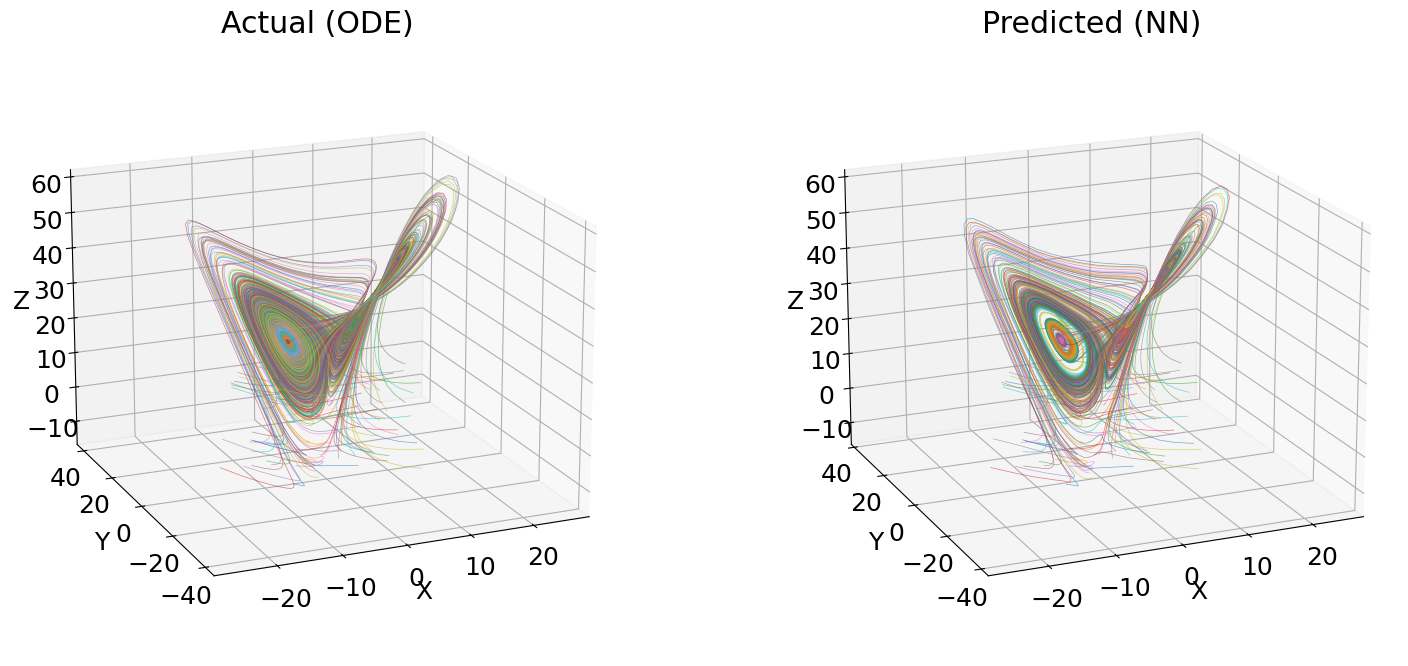

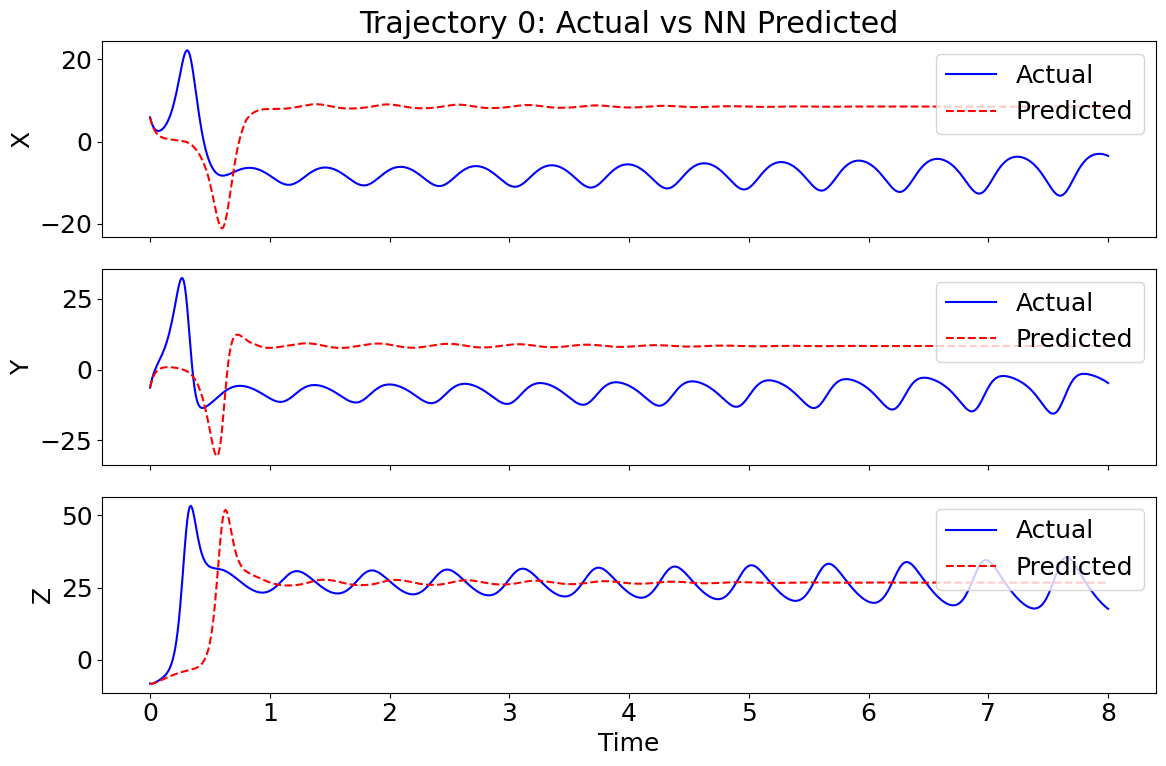

In [13]:
## Visualize: Predicted (NN) vs Actual (ODE) Trajectories

fig = plt.figure(figsize=(16, 7))

# --- Actual trajectories (from ODE integration) ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
for j in range(num_traj):
    x, y, z = x_t[j, :, :].T
    ax1.plot(x, y, z, linewidth=0.5, alpha=0.6)
ax1.set_title('Actual (ODE)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.view_init(18, -113)

# --- NN-predicted trajectories ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
for j in range(num_traj):
    x, y, z = ynn[j, :, :].T
    ax2.plot(x, y, z, linewidth=0.5, alpha=0.6)
ax2.set_title('Predicted (NN)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.view_init(18, -113)

plt.tight_layout()
plt.show()

# --- Time-series comparison for a single trajectory ---
traj_idx = 0
fig2, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
labels = ['X', 'Y', 'Z']
for i, ax in enumerate(axes):
    ax.plot(t, x_t[traj_idx, :, i], 'b', label='Actual', linewidth=1.5)
    ax.plot(t, ynn[traj_idx, :, i], 'r--', label='Predicted', linewidth=1.5)
    ax.set_ylabel(labels[i])
    ax.legend(loc='upper right')
axes[-1].set_xlabel('Time')
axes[0].set_title(f'Trajectory {traj_idx}: Actual vs NN Predicted')
plt.tight_layout()
plt.show()

# LSTM

In [6]:
sequence_size = 40; train_size = 80; test_size = 20
rnn_input = np.zeros((train_size*(len(t)-sequence_size-1),
sequence_size, 3))
rnn_output = np.zeros((train_size*(len(t)-sequence_size-1),
3))

In [7]:
# --- Prepare RNN training data ---
for j in range(train_size):
    for k in range(len(t) - sequence_size - 1):
        idx = j * (len(t) - sequence_size - 1) + k
        rnn_input[idx, :, :] = x_t[j, k:k+sequence_size, :]
        rnn_output[idx, :]   = x_t[j, k+sequence_size, :]

# --- Normalize ---
rnn_input_mean = rnn_input.reshape(-1, 3).mean(axis=0)
rnn_input_std  = rnn_input.reshape(-1, 3).std(axis=0)
rnn_output_mean = rnn_output.mean(axis=0)
rnn_output_std  = rnn_output.std(axis=0)

rnn_input_norm  = (rnn_input  - rnn_input_mean) / rnn_input_std
rnn_output_norm = (rnn_output - rnn_output_mean) / rnn_output_std

# --- Build & train LSTM model ---
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(sequence_size, 3)))
lstm_model.add(Dense(3))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
lstm_model.fit(rnn_input_norm, rnn_output_norm, epochs=20, batch_size=256, validation_split=0.1)

Epoch 1/20


/Users/tzikos/Desktop/DTU/4th Semester/Data-driven methods/Exercises/Data-Driven-Methods/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


214/214 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0453 - val_loss: 4.7485e-04
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 2.5583e-04 - val_loss: 1.1018e-04
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 9.9360e-05 - val_loss: 4.9656e-05
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 5.1674e-05 - val_loss: 2.7240e-05
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 3.0785e-05 - val_loss: 1.8281e-05
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 2.0037e-05 - val_loss: 1.5255e-05
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 1.3481e-05 - val_loss: 1.2209e-05
Epoch 8/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 9.9018e-06 - val_loss: 6.0114e-06
Epoch 9/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 8.1658e-06 - val_loss: 6.5077e-06
Epoch 10/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 5.9383e-06 - val_loss: 5.2135e-06
Epoch 11/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 5.

In [8]:
## Predict test trajectories using LSTM (autoregressively)

# Use the held-out test trajectories (indices train_size : train_size+test_size)
y_lstm = np.zeros((test_size, len(t), 3))

# Seed with the first `sequence_size` true time steps
y_lstm[:, :sequence_size, :] = x_t[train_size:train_size+test_size, :sequence_size, :]

for jj in range(sequence_size, len(t)):
    # Take the last `sequence_size` steps as input window
    window = y_lstm[:, jj-sequence_size:jj, :]                   # (test_size, sequence_size, 3)
    window_norm = (window - rnn_input_mean) / rnn_input_std
    pred_norm = lstm_model.predict(window_norm, verbose=0)        # (test_size, 3)
    y_lstm[:, jj, :] = pred_norm * rnn_output_std + rnn_output_mean

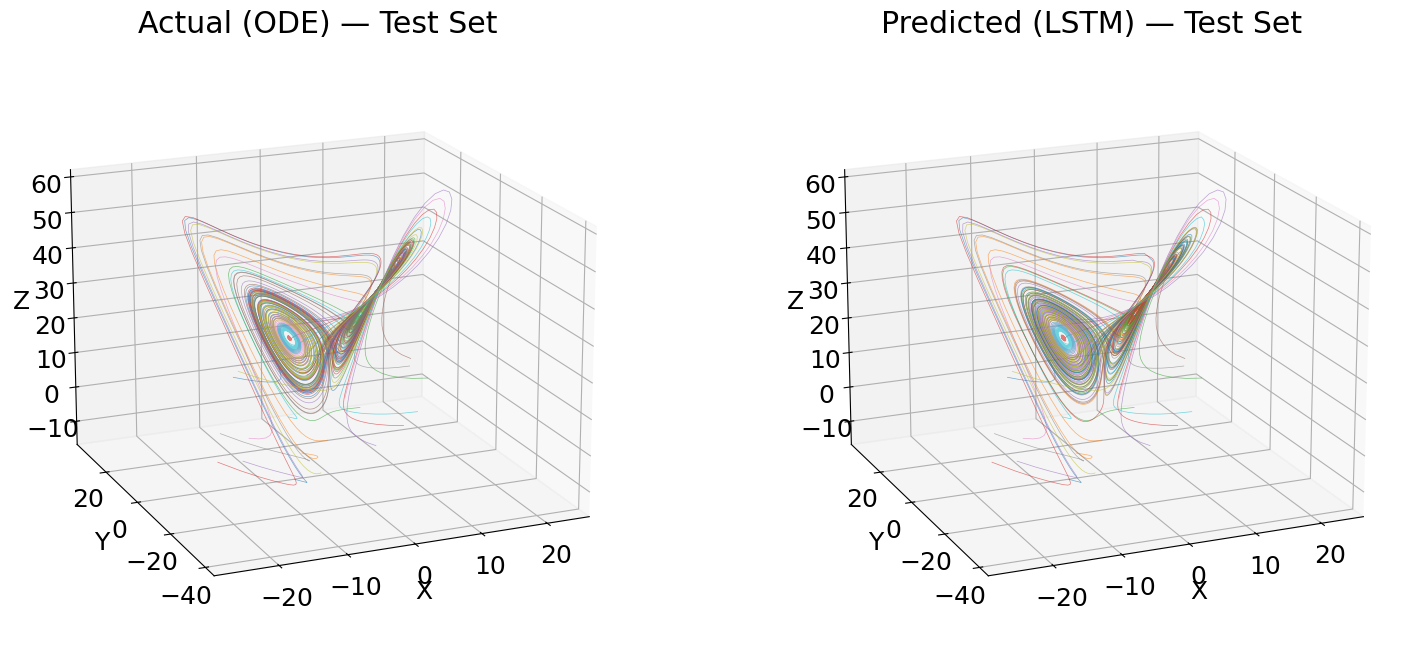

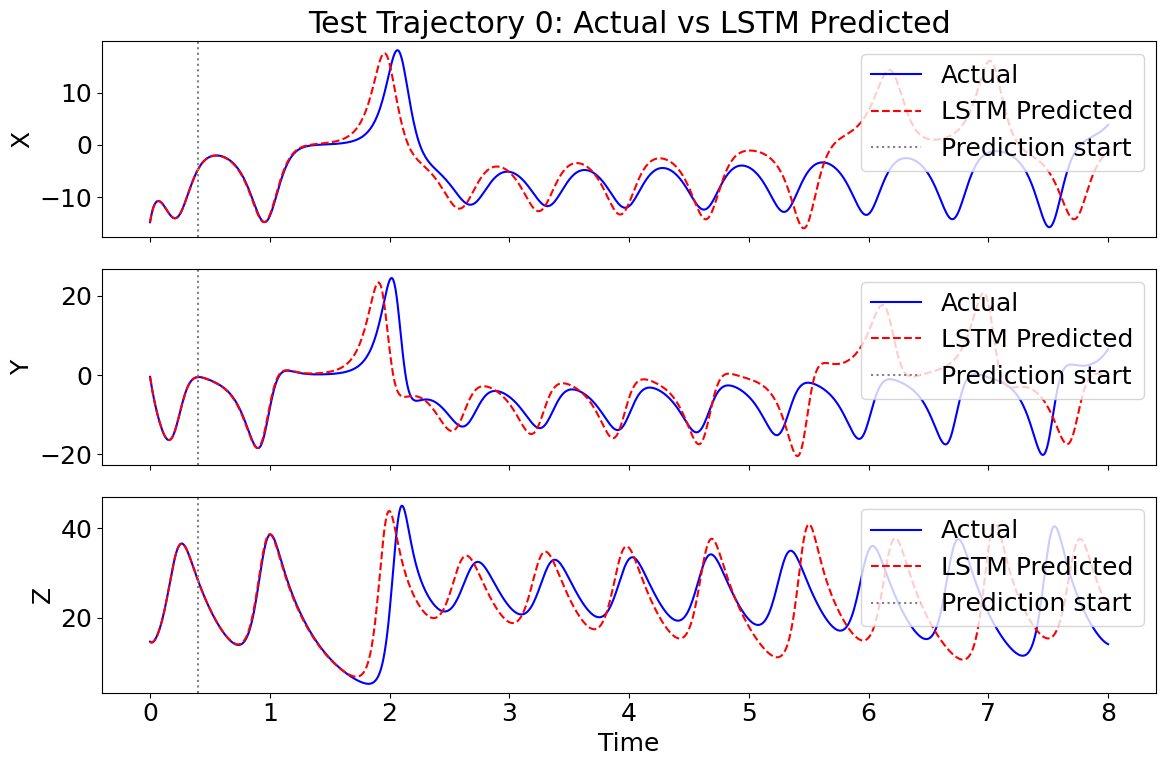

In [9]:
## Visualize: LSTM Predicted vs Actual Trajectories

fig = plt.figure(figsize=(16, 7))

# --- Actual test trajectories ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
for j in range(test_size):
    xj, yj, zj = x_t[train_size + j, :, :].T
    ax1.plot(xj, yj, zj, linewidth=0.5, alpha=0.6)
ax1.set_title('Actual (ODE) — Test Set')
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
ax1.view_init(18, -113)

# --- LSTM predicted trajectories ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
for j in range(test_size):
    xj, yj, zj = y_lstm[j, :, :].T
    ax2.plot(xj, yj, zj, linewidth=0.5, alpha=0.6)
ax2.set_title('Predicted (LSTM) — Test Set')
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
ax2.view_init(18, -113)

plt.tight_layout()
plt.show()

# --- Time-series comparison for one test trajectory ---
traj_idx = 0
fig2, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
labels = ['X', 'Y', 'Z']
for i, ax in enumerate(axes):
    ax.plot(t, x_t[train_size + traj_idx, :, i], 'b', label='Actual', linewidth=1.5)
    ax.plot(t, y_lstm[traj_idx, :, i], 'r--', label='LSTM Predicted', linewidth=1.5)
    ax.axvline(x=t[sequence_size], color='gray', linestyle=':', label='Prediction start')
    ax.set_ylabel(labels[i])
    ax.legend(loc='upper right')
axes[-1].set_xlabel('Time')
axes[0].set_title(f'Test Trajectory {traj_idx}: Actual vs LSTM Predicted')
plt.tight_layout()
plt.show()

# Transformer

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, num_layers, nhead, dim_feedforward=512, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        d_model = nhead * 4  # must be divisible by nhead
        self.input_projection = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_linear = nn.Linear(d_model * sequence_size, input_dim)

    def forward(self, src):
        src = self.input_projection(src)             # (batch, seq_len, d_model)
        out = self.transformer_encoder(src)          # (batch, seq_len, d_model)
        out = out.reshape(out.size(0), -1)           # (batch, seq_len * d_model)
        return self.output_linear(out)               # (batch, input_dim)

Using device: cpu


In [18]:
## Prepare data for Transformer — predict RESIDUAL (Δx) instead of absolute state

# Vectorized sliding-window construction (much faster than double loop)
n_steps = len(t)
samples_per_traj = n_steps - sequence_size - 1
idx_k = np.arange(samples_per_traj)

tr_input  = np.zeros((train_size * samples_per_traj, sequence_size, 3))
tr_output = np.zeros((train_size * samples_per_traj, 3))

for j in range(train_size):
    slices = j * samples_per_traj + idx_k
    # Vectorized: build all windows for trajectory j at once
    starts = idx_k[:, None] + np.arange(sequence_size)[None, :]   # (samples_per_traj, sequence_size)
    tr_input[slices]  = x_t[j, starts, :]                         # fancy indexing
    last_state        = x_t[j, idx_k + sequence_size - 1, :]      # last input state
    next_state        = x_t[j, idx_k + sequence_size, :]          # target state
    tr_output[slices] = next_state - last_state                    # RESIDUAL Δx

# Normalize
tr_input_mean  = tr_input.reshape(-1, 3).mean(axis=0)
tr_input_std   = tr_input.reshape(-1, 3).std(axis=0)
tr_output_mean = tr_output.mean(axis=0)
tr_output_std  = tr_output.std(axis=0)

tr_input_norm  = (tr_input  - tr_input_mean) / tr_input_std
tr_output_norm = (tr_output - tr_output_mean) / tr_output_std

# Convert to PyTorch tensors
X_train = torch.FloatTensor(tr_input_norm)
y_train = torch.FloatTensor(tr_output_norm)

train_dataset = TensorDataset(X_train, y_train)
train_loader  = DataLoader(train_dataset, batch_size=512, shuffle=True)

print(f"Training samples: {X_train.shape[0]}")
print(f"Output (residual) mean magnitude: {np.abs(tr_output).mean():.4f}")
print(f"Output (residual) std: {tr_output.std(axis=0)}")

Training samples: 60800
Output (residual) mean magnitude: 0.3439
Output (residual) std: [0.34111879 0.50666574 0.6140305 ]


In [19]:
## Train the Transformer (with LR scheduler)
from tqdm import tqdm

input_dim = 3
num_layers = 3
nhead = 4
dim_feedforward = 128
num_epochs = 30

transformer_model = TimeSeriesTransformer(
    input_dim=input_dim, num_layers=num_layers,
    nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in tqdm(range(num_epochs), desc="Training Transformer"):
    transformer_model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        pred = transformer_model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    scheduler.step()
    epoch_loss /= len(train_loader.dataset)

Training Transformer: 100%|██████████| 30/30 [14:28<00:00, 28.94s/it]


In [20]:
## Predict test trajectories — add predicted residual to last state

transformer_model.eval()
y_transformer = np.zeros((test_size, len(t), 3))

# Seed with the first `sequence_size` true time steps
y_transformer[:, :sequence_size, :] = x_t[train_size:train_size+test_size, :sequence_size, :]

with torch.no_grad():
    for jj in range(sequence_size, len(t)):
        window = y_transformer[:, jj-sequence_size:jj, :]
        window_norm = (window - tr_input_mean) / tr_input_std
        window_tensor = torch.FloatTensor(window_norm).to(device)
        pred_norm = transformer_model(window_tensor).cpu().numpy()
        # Denormalize to get Δx, then add to last state
        delta = pred_norm * tr_output_std + tr_output_mean
        y_transformer[:, jj, :] = y_transformer[:, jj-1, :] + delta

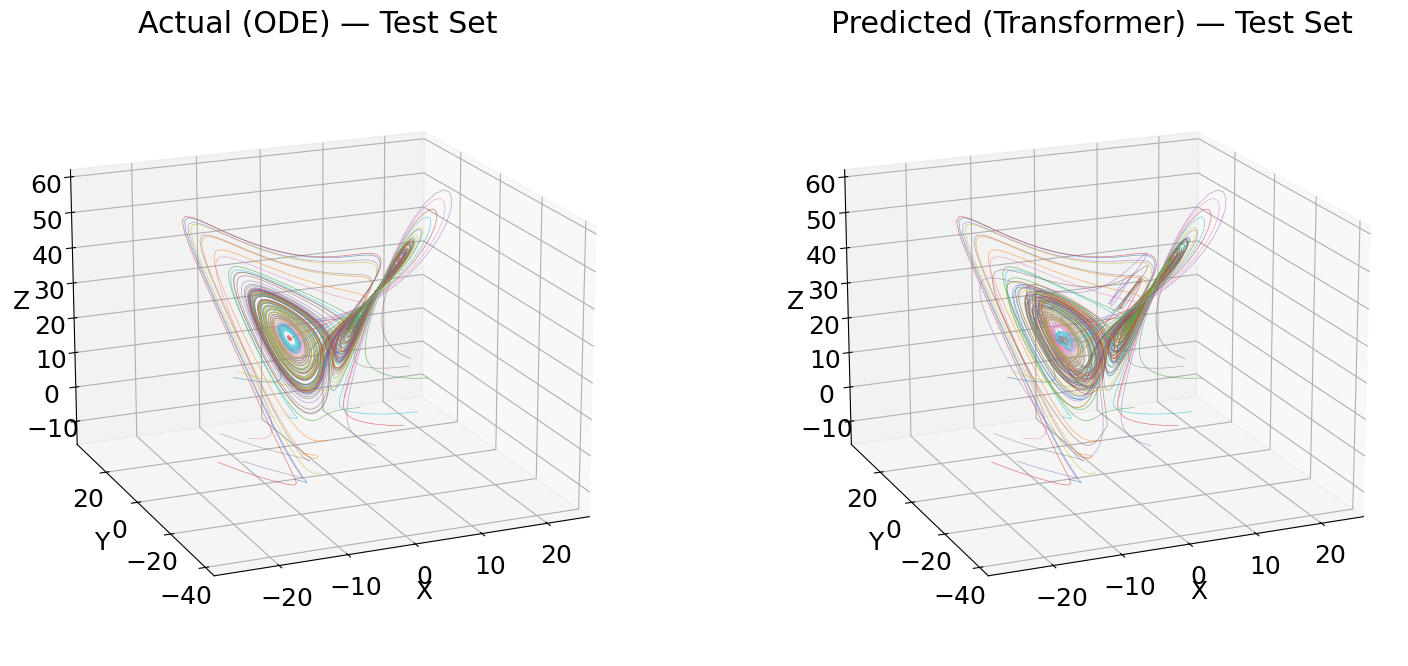

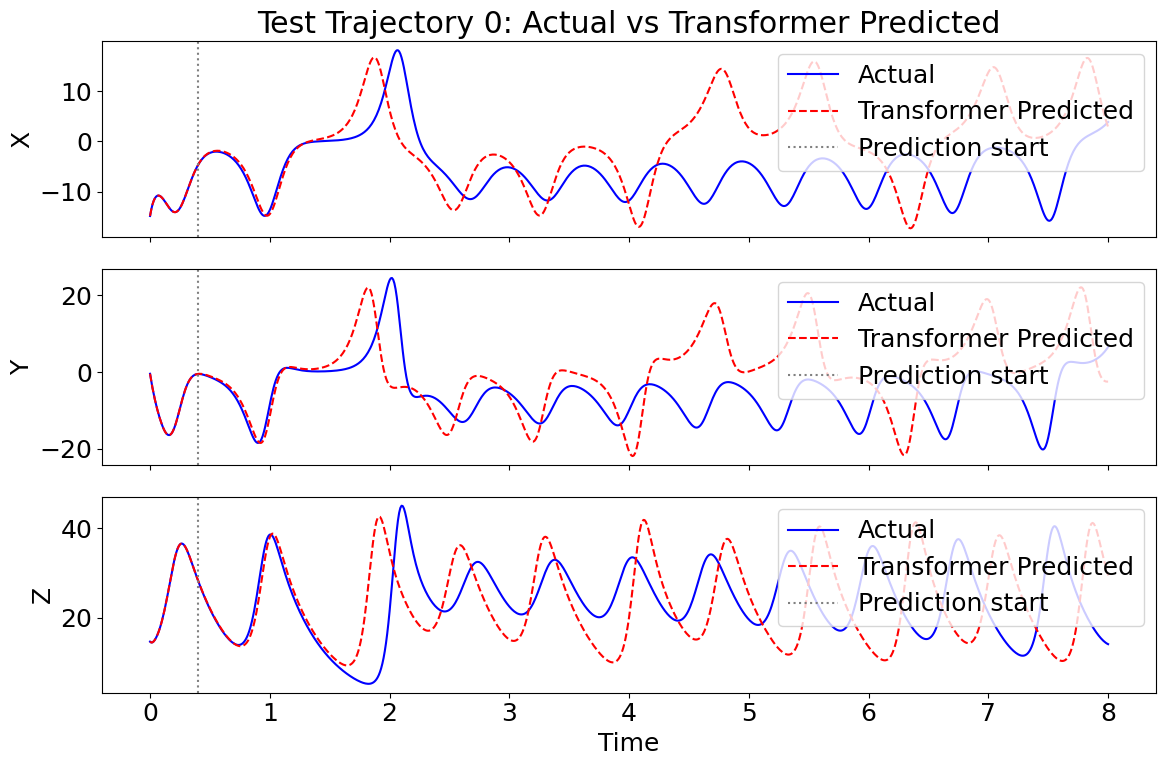

In [21]:
## Visualize: Transformer Predicted vs Actual Trajectories

fig = plt.figure(figsize=(16, 7))

# --- Actual test trajectories ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
for j in range(test_size):
    xj, yj, zj = x_t[train_size + j, :, :].T
    ax1.plot(xj, yj, zj, linewidth=0.5, alpha=0.6)
ax1.set_title('Actual (ODE) — Test Set')
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
ax1.view_init(18, -113)

# --- Transformer predicted trajectories ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
for j in range(test_size):
    xj, yj, zj = y_transformer[j, :, :].T
    ax2.plot(xj, yj, zj, linewidth=0.5, alpha=0.6)
ax2.set_title('Predicted (Transformer) — Test Set')
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
ax2.view_init(18, -113)

plt.tight_layout()
plt.show()

# --- Time-series comparison for one test trajectory ---
traj_idx = 0
fig2, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
labels = ['X', 'Y', 'Z']
for i, ax in enumerate(axes):
    ax.plot(t, x_t[train_size + traj_idx, :, i], 'b', label='Actual', linewidth=1.5)
    ax.plot(t, y_transformer[traj_idx, :, i], 'r--', label='Transformer Predicted', linewidth=1.5)
    ax.axvline(x=t[sequence_size], color='gray', linestyle=':', label='Prediction start')
    ax.set_ylabel(labels[i])
    ax.legend(loc='upper right')
axes[-1].set_xlabel('Time')
axes[0].set_title(f'Test Trajectory {traj_idx}: Actual vs Transformer Predicted')
plt.tight_layout()
plt.show()